In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# Mô hình huấn luyện
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score,RocCurveDisplay, PrecisionRecallDisplay,confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

#Hàm visualize
def viz_dataset(X, y):
    x_transformed = PCA(n_components=2).fit_transform(X)
    sns.scatterplot(x=x_transformed[:, 0], y=x_transformed[:,1], hue=y)

#Hàm vẽ curves
def viz_curves(classifier, X, y):
    RocCurveDisplay.from_estimator(classifier, X, y)
    display = PrecisionRecallDisplay.from_estimator(
        classifier, X, y)
        
def show_confusion_matrix(y_pred, y_true, title=''):
    cf = confusion_matrix(y_true, y_pred)
    labels = np.unique(y_true)
    labels = [str(l) for l in labels]

1. Kết hợp SMOTE và undersampling: undersampling non-fraud, sau đó áp dụng SMOTE
2. Sử dụng cross validation để cải thiện vấn đề overfitting: kết hợp SMOTE (tham khảo: https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7)
3. Thí nghiệm với các phương pháp phân loại đã học (Logistic regression, KNN, RandomForest), và so sánh với SVM. Vẽ biểu đồ so sánh precision và recall của các loại mô hình.

In [3]:
# Đọc file 
credit_df = pd.read_csv('creditcard.csv')
credit_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#Bỏ cột Time
credit_df.drop(['Time'], axis=1, inplace=True)
credit_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
np.unique(credit_df['Class'].to_numpy(), return_counts=True)

(array([0, 1], dtype=int64), array([284315,    492], dtype=int64))

In [6]:
#Quick pie
fraud_df = credit_df[credit_df['Class'] == 1]
non_fraud_df = credit_df[credit_df['Class'] == 0]

total_fraud_normal=credit_df['Class'].value_counts().to_list()

origin_data=[fraud_df,non_fraud_df]

fig=px.pie(values=total_fraud_normal,names=['Normal','Fraud'],title='The percentage of transaction')
fig.show()

In [7]:
#Chuẩn hóa dữ liệu
from sklearn.preprocessing import StandardScaler

credit_df['Amount'] = StandardScaler().fit_transform(credit_df['Amount'].values.reshape(-1, 1))


# Chia data
df = credit_df.sample(frac=1)
X = df.drop('Class', axis=1)
y = df['Class']

sk = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# Tập origin
for train_index, test_index in sk.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# data undersampling
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492] # Có 492 dòng dữ liệu lỗi 

normal_distributed_df = pd.concat([fraud_df, non_fraud_df],axis=0) # Nối 2 cột dữ liệu đã giảm khối lượng xuống

# Trộn lại dòng dữ liệu sau khi giảm mẫu
new_df = normal_distributed_df.sample(frac=1, random_state=39)


Train: [ 56962  56963  56964 ... 284804 284805 284806] Test: [    0     1     2 ... 56959 56960 56961]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56962  56963  56964 ... 113921 113922 114520]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113923 113924 113925 ... 179959 180407 180447]
Train: [     0      1      2 ... 284804 284805 284806] Test: [170871 170872 170873 ... 237758 237861 238399]
Train: [     0      1      2 ... 237758 237861 238399] Test: [227830 227831 227832 ... 284804 284805 284806]


In [8]:
normal_distributed_df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
108258,0.196707,1.189757,0.704882,2.891388,0.045555,1.245730,-1.198714,-2.421616,-1.232089,0.324239,...,-1.328132,0.189311,-0.005524,-0.814708,0.400924,0.286281,0.135215,0.257315,-0.350191,1
249607,-7.381547,-7.449015,-4.696287,3.728439,6.198304,-6.406267,-5.831452,1.457175,-0.646203,-4.029129,...,1.176575,-0.978692,-0.278330,-0.635874,0.123539,0.404729,0.704915,-1.229992,-0.213296,1
15166,-18.474868,11.586381,-21.402917,6.038515,-14.451158,-4.146524,-14.856124,12.431140,-4.053353,-9.040396,...,1.741136,-1.251138,-0.396219,0.095706,1.322751,-0.217955,1.628793,0.482248,0.046539,1
249239,-0.082983,-3.935919,-2.616709,0.163310,-1.400952,-0.809419,1.501580,-0.471000,1.519743,-1.134454,...,0.702672,-0.182305,-0.921017,0.111635,-0.071622,-1.125881,-0.170947,0.126221,4.032631,1
189587,0.909124,1.337658,-4.484728,3.245358,-0.417809,-0.762119,-2.506349,0.694164,-0.467556,-4.565260,...,0.586829,0.594078,-0.252120,0.325439,0.562766,-0.256278,0.652674,0.319879,-0.081759,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113282,1.012352,-1.121569,1.538699,1.001187,-1.622202,1.031187,-1.303591,0.396565,0.270474,0.538992,...,-0.405240,-0.420283,-0.125567,0.008782,0.430065,-0.284857,0.110395,0.045414,0.046579,0
254016,-0.704118,0.811679,-0.719919,-0.283961,0.034469,-0.065706,-0.235422,0.877339,-0.302066,-0.559983,...,0.149254,0.189848,-0.053465,-1.020203,-0.737830,0.207965,-0.225414,-0.119795,-0.205700,0
274487,2.106631,-0.196378,-1.636610,-0.023673,0.555858,-0.032235,-0.008131,-0.035276,0.477568,0.255557,...,-0.329915,-0.872322,0.172288,-1.464100,-0.182870,0.271241,-0.077660,-0.086065,-0.345313,0
187953,2.231878,-1.559819,-1.445668,-1.849293,-0.655773,0.176850,-1.063509,-0.096683,-1.463735,1.695820,...,-0.063920,0.254851,-0.061389,-1.422805,0.037880,-0.003483,0.004042,-0.064959,-0.063368,0


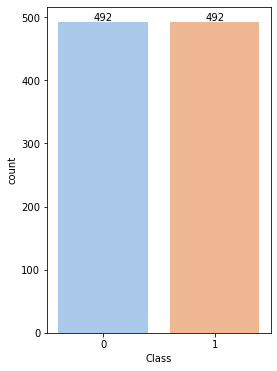

In [9]:
# Quick visualize tập train đã giảm mẫu
plt.figure(figsize=(4,6))
ax=sns.countplot(x="Class",data=new_df,palette="pastel")

for i in ax.containers:
    ax.bar_label(i,)

array([492, 492], dtype=int64)

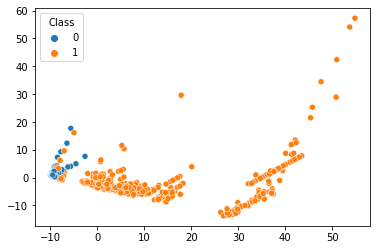

In [10]:
# Undersampling trước khi chia data và cross validating

X=new_df.drop(['Class'], axis=1)
y=new_df['Class']

viz_dataset(X,y)
np.bincount(y)

In [11]:
# Chia tập data undersampling để train 

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(787, 29)
(197, 29)
(787,)
(197,)


In [12]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "RandomForestClassifier": RandomForestClassifier()
}

In [13]:
# Under sampling

from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 94.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 94.0 % accuracy score
Classifiers:  SVC Has a training score of 94.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 94.0 % accuracy score


In [14]:
# Dùng GridSearchCV để tìm tham số tốt nhất cho undersampling
from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)

grid_log_reg.fit(X_train, y_train)

log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# RandomForest Classifier

forest_params = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}
grid_forest = GridSearchCV(RandomForestClassifier(), forest_params)
grid_forest.fit(X_train, y_train)

# forest best estimator
forest_clf = grid_forest.best_estimator_

c:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\Admin\anaconda3\lib\site-packages

In [15]:
# Overfitting

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

forest_score = cross_val_score(forest_clf, X_train, y_train, cv=5)
print('Randomforest Classifier Cross Validation Score', round(forest_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  94.91%
Knears Neighbors Cross Validation Score 93.9%
Support Vector Classifier Cross Validation Score 94.03%
Randomforest Classifier Cross Validation Score 94.28%


In [16]:
# Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator Logistic
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator  KNN
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14) ###
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator SVC
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14) ###
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator Random Forest Classifier
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Random Forest Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'c:\\Users\\Admin\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

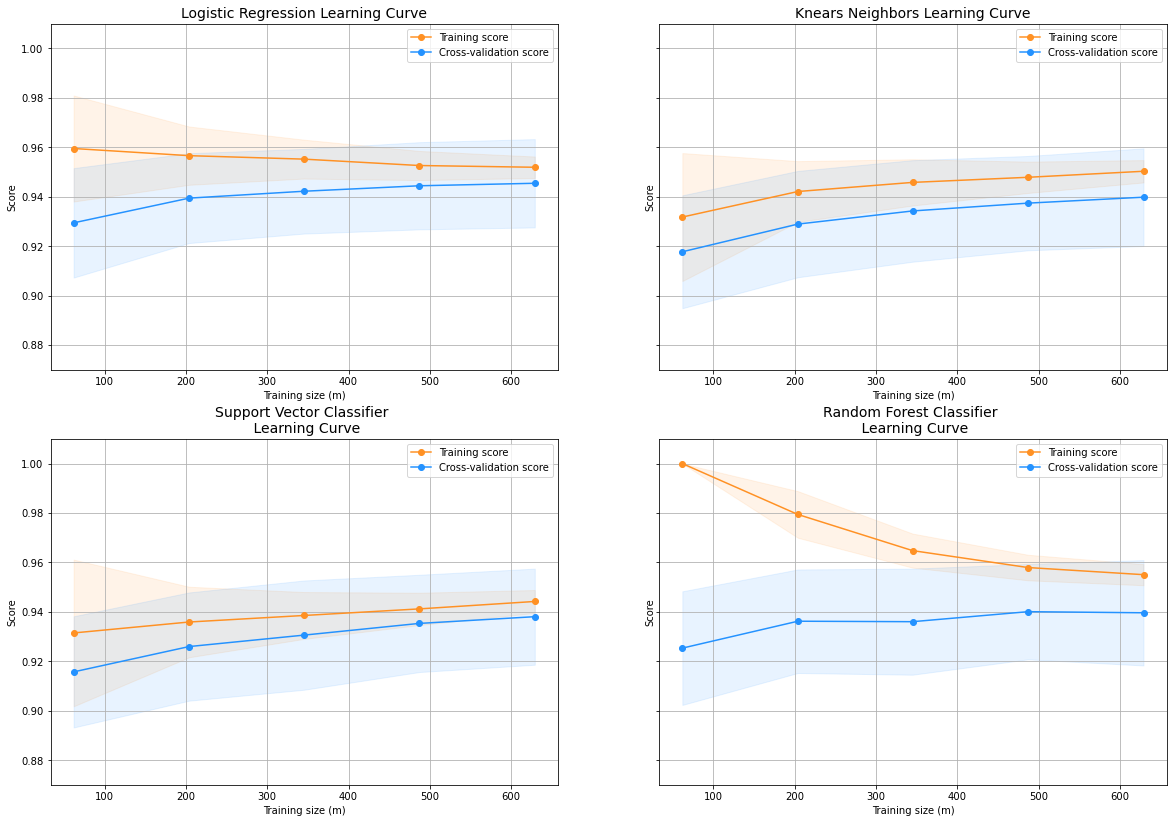

In [26]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=37)
plot_learning_curve(log_reg, knears_neighbors, svc, forest_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [20]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# predict với cross_val

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

forest_pred = cross_val_predict(forest_clf, X_train, y_train, cv=5)

Logistic Regression:  0.9807443867400459
KNears Neighbors:  0.9382864377438441
Support Vector Classifier:  0.9809317107200992
Random Forest Classifier:  0.9382509107821099


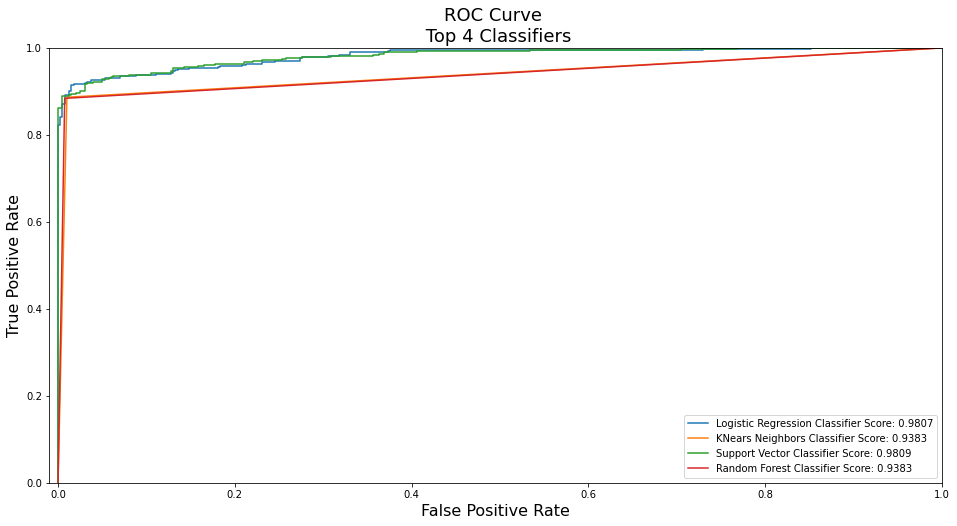

In [25]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Random Forest Classifier: ', roc_auc_score(y_train, forest_pred))

log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, forest_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_train, forest_pred)))

    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()